# Modelo 2: Clasificación multiclase por nivel de rendimiento

# Librerías necesarias

In [ ]:
# Importar librerías

from dotenv import load_dotenv
import os

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Desarrollo de la técnica de árbol de clasificación multiclase

              precision    recall  f1-score   support

        alto       0.87      0.89      0.88       363
        bajo       0.93      0.84      0.88       364
       medio       0.74      0.80      0.77       362

    accuracy                           0.84      1089
   macro avg       0.85      0.84      0.84      1089
weighted avg       0.85      0.84      0.84      1089



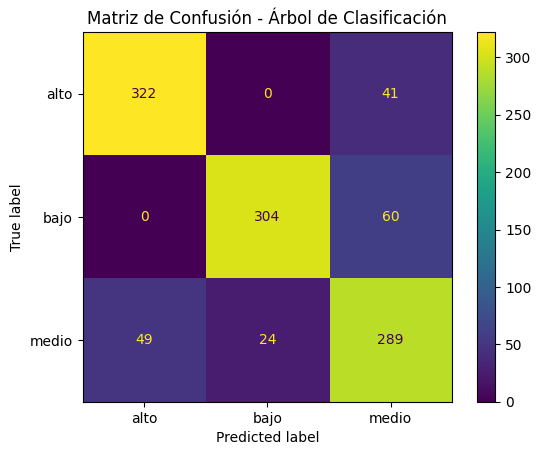

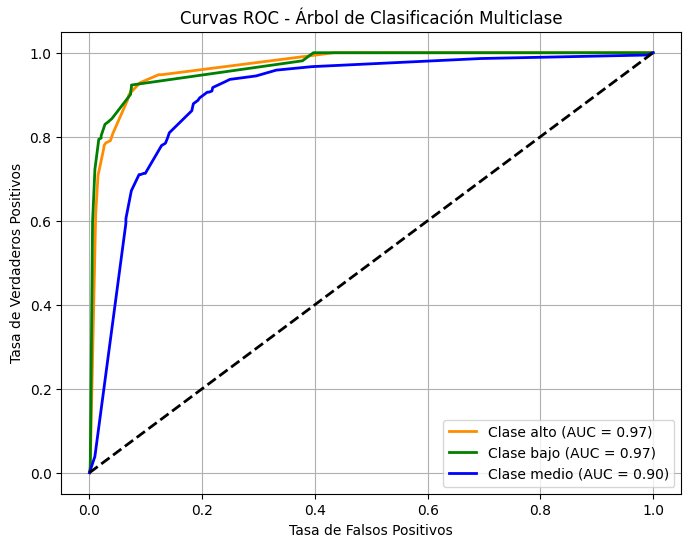

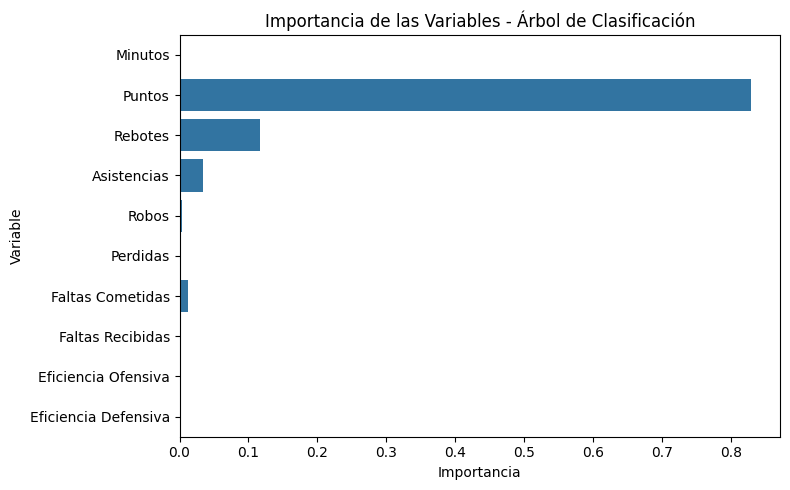

In [10]:
load_dotenv()

# Cargar el dataset
df = pd.read_csv(os.getenv("TRANSFORM_DATA_PATH"), sep=";")

# Crear variable objetivo: rendimiento multiclase (bajo, medio, alto) según la valoración
df["nivel_rendimiento"] = pd.qcut(df["Valoracion"], q=3, labels=["bajo", "medio", "alto"])
le = LabelEncoder()
df["clase_rendimiento"] = le.fit_transform(df["nivel_rendimiento"])  # 0: bajo, 1: medio, 2: alto

# Variables predictoras
features = [
    "Minutos", "Puntos", "Rebotes", "Asistencias", "Robos",
    "Perdidas", "Faltas Cometidas", "Faltas Recibidas",
    "Eficiencia Ofensiva", "Eficiencia Defensiva"
]

X = df[features]
y = df["clase_rendimiento"]

# División en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Binarización para curvas ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Pipeline: imputación + árbol
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("clf", DecisionTreeClassifier(max_depth=5, random_state=42))
])

# Entrenar
pipeline.fit(X_train, y_train)

# Predicciones
y_pred = pipeline.predict(X_test)

# Evaluación
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, display_labels=le.classes_)
plt.title("Matriz de Confusión - Árbol de Clasificación")
plt.show()

# Curvas ROC
y_score = pipeline.named_steps["clf"].predict_proba(pipeline.named_steps["imputer"].transform(X_test))

plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue']
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'Clase {le.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC - Árbol de Clasificación Multiclase')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Importancia de variables
# Obtener la importancia desde el árbol del pipeline
importances = pipeline.named_steps["clf"].feature_importances_

# Graficar
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.title("Importancia de las Variables - Árbol de Clasificación")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# Desarrollo de la técnica de random forest multiclase

              precision    recall  f1-score   support

        alto       0.89      0.91      0.90       363
        bajo       0.93      0.89      0.91       364
       medio       0.81      0.83      0.82       362

    accuracy                           0.88      1089
   macro avg       0.88      0.88      0.88      1089
weighted avg       0.88      0.88      0.88      1089



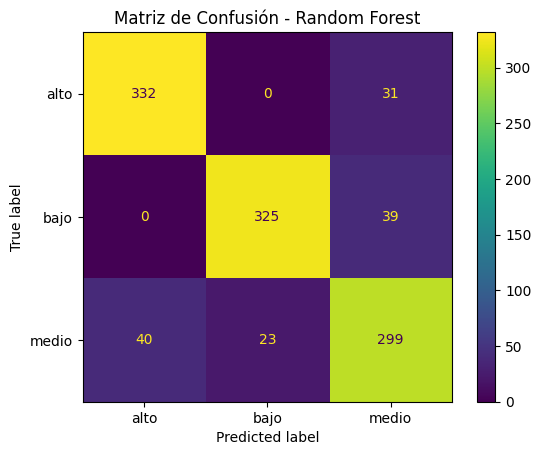

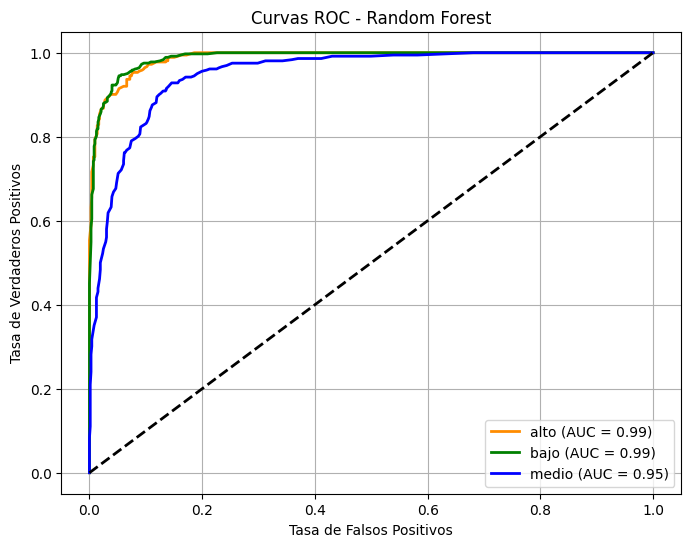

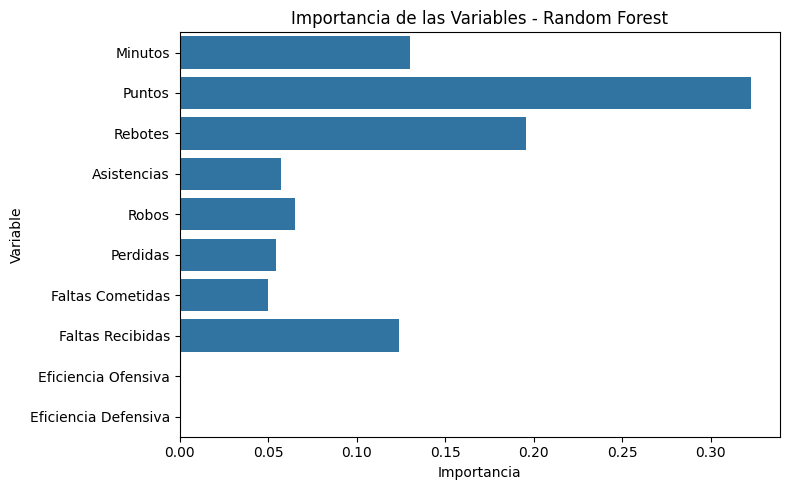

In [11]:
# Cargar el dataset
df = pd.read_csv(os.getenv("TRANSFORM_DATA_PATH"), sep=";")

# Crear variable de clasificación por nivel de rendimiento
df["nivel_rendimiento"] = pd.qcut(df["Valoracion"], q=3, labels=["bajo", "medio", "alto"])
le = LabelEncoder()
df["clase_rendimiento"] = le.fit_transform(df["nivel_rendimiento"])  # 0 = bajo, 1 = medio, 2 = alto

# Definir variables predictoras
features = [
    "Minutos", "Puntos", "Rebotes", "Asistencias", "Robos",
    "Perdidas", "Faltas Cometidas", "Faltas Recibidas",
    "Eficiencia Ofensiva", "Eficiencia Defensiva"
]
X = df[features]
y = df["clase_rendimiento"]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Pipeline con imputación y modelo
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entrenar modelo
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Mostrar métricas
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, display_labels=le.classes_)
plt.title("Matriz de Confusión - Random Forest")
plt.show()

# Curvas ROC
y_score = pipeline.named_steps["clf"].predict_proba(pipeline.named_steps["imputer"].transform(X_test))
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue']
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[i], label=f"{le.classes_[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curvas ROC - Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Importancia de variables
importances = pipeline.named_steps["clf"].feature_importances_
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.title("Importancia de las Variables - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# Desarrollo de la técnica de redes neuronales multicapa

              precision    recall  f1-score   support

        alto       0.93      0.93      0.93       363
        bajo       0.95      0.93      0.94       364
       medio       0.87      0.88      0.87       362

    accuracy                           0.91      1089
   macro avg       0.91      0.91      0.91      1089
weighted avg       0.92      0.91      0.91      1089



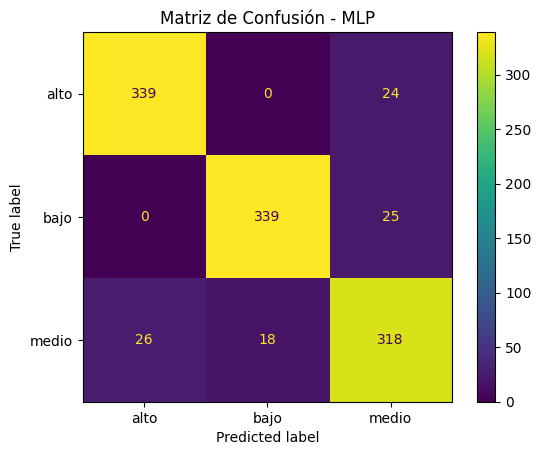

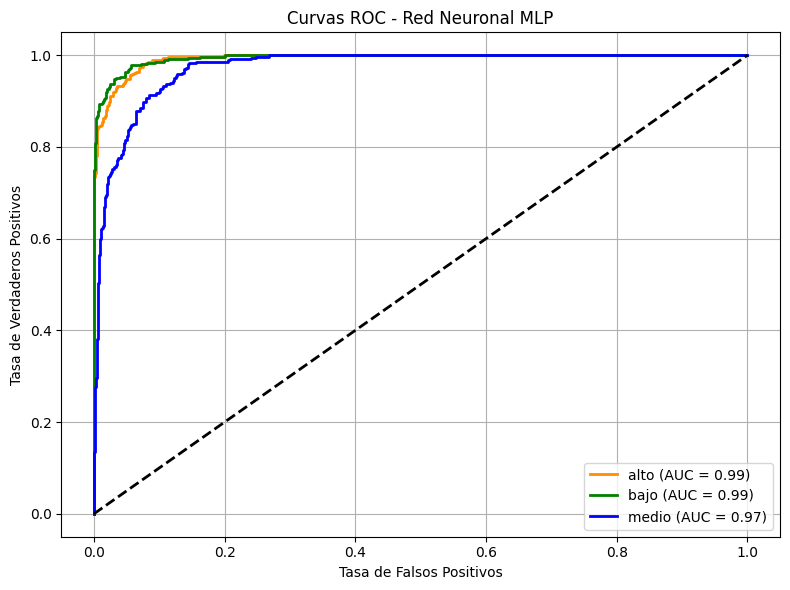

In [13]:
# Cargar el dataset
df = pd.read_csv(os.getenv("TRANSFORM_DATA_PATH"), sep=";")

# Crear variable de rendimiento multiclase
df["nivel_rendimiento"] = pd.qcut(df["Valoracion"], q=3, labels=["bajo", "medio", "alto"])
le = LabelEncoder()
df["clase_rendimiento"] = le.fit_transform(df["nivel_rendimiento"])  # 0 = bajo, 1 = medio, 2 = alto

# Definir variables predictoras
features = [
    "Minutos", "Puntos", "Rebotes", "Asistencias", "Robos",
    "Perdidas", "Faltas Cometidas", "Faltas Recibidas",
    "Eficiencia Ofensiva", "Eficiencia Defensiva"
]
X = df[features]
y = df["clase_rendimiento"]

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Crear pipeline con imputación y red neuronal
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("clf", MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
])

# Entrenar modelo
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, display_labels=le.classes_)
plt.title("Matriz de Confusión - MLP")
plt.show()

# Curvas ROC
y_score = pipeline.named_steps["clf"].predict_proba(pipeline.named_steps["imputer"].transform(X_test))

plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue']
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[i], label=f"{le.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curvas ROC - Red Neuronal MLP")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Desarrollo de la técnica de SVM multiclase (uno vs todos)

              precision    recall  f1-score   support

        alto       0.89      0.88      0.89       363
        bajo       0.92      0.88      0.90       364
       medio       0.77      0.82      0.80       362

    accuracy                           0.86      1089
   macro avg       0.86      0.86      0.86      1089
weighted avg       0.86      0.86      0.86      1089



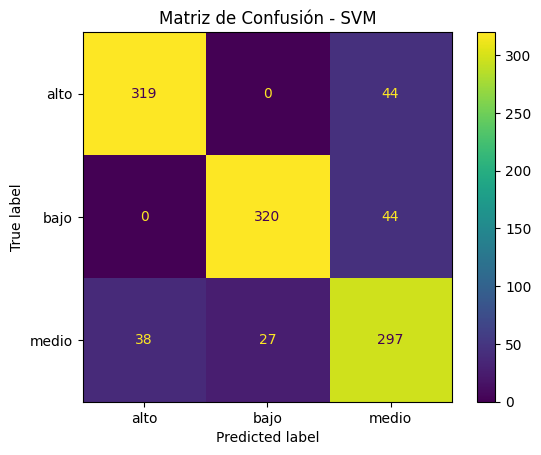

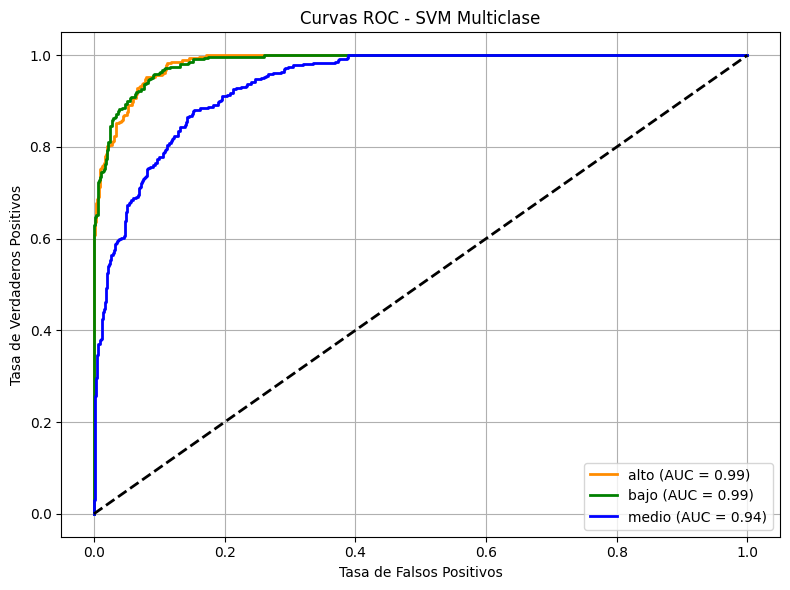

In [15]:
# Cargar el dataset
df = pd.read_csv(os.getenv("TRANSFORM_DATA_PATH"), sep=";")

# Crear variable multiclase
df["nivel_rendimiento"] = pd.qcut(df["Valoracion"], q=3, labels=["bajo", "medio", "alto"])
le = LabelEncoder()
df["clase_rendimiento"] = le.fit_transform(df["nivel_rendimiento"])

# Variables predictoras
features = [
    "Minutos", "Puntos", "Rebotes", "Asistencias", "Robos",
    "Perdidas", "Faltas Cometidas", "Faltas Recibidas",
    "Eficiencia Ofensiva", "Eficiencia Defensiva"
]
X = df[features]
y = df["clase_rendimiento"]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Pipeline con SVM One-vs-Rest
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("clf", OneVsRestClassifier(SVC(kernel='rbf', probability=True, decision_function_shape='ovr', random_state=42)))
])

# Entrenar modelo
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_score = pipeline.predict_proba(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, display_labels=le.classes_)
plt.title("Matriz de Confusión - SVM")
plt.show()

# Curvas ROC
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue']
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[i], label=f"{le.classes_[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curvas ROC - SVM Multiclase")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Comparativa de resultados entre los modelos

In [18]:
# Cargar el dataset
df = pd.read_csv(os.getenv("TRANSFORM_DATA_PATH"), sep=";")

df["nivel_rendimiento"] = pd.qcut(df["Valoracion"], q=3, labels=["bajo", "medio", "alto"])
le = LabelEncoder()
df["clase_rendimiento"] = le.fit_transform(df["nivel_rendimiento"])

# Variables
features = [
    "Minutos", "Puntos", "Rebotes", "Asistencias", "Robos",
    "Perdidas", "Faltas Cometidas", "Faltas Recibidas",
    "Eficiencia Ofensiva", "Eficiencia Defensiva"
]
X = df[features]
y = df["clase_rendimiento"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Necesario para AUC multiclase

# Diccionario de modelos
modelos = {
    "Árbol de Decisión": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Red Neuronal MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "SVM One-vs-Rest": OneVsRestClassifier(SVC(kernel='rbf', probability=True, random_state=42))
}

# Evaluación
resultados = []

for nombre, modelo in modelos.items():
    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("clf", modelo)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Inicializar AUC
    auc_micro = auc_macro = None

    # Intentar calcular AUC si el modelo lo permite
    try:
        # Es importante transformar los datos antes si hay imputación
        X_test_imputado = pipeline.named_steps["imputer"].transform(X_test)
        y_score = pipeline.named_steps["clf"].predict_proba(X_test_imputado)
        auc_micro = roc_auc_score(y_test_bin, y_score, average="micro", multi_class="ovr")
        auc_macro = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
    except Exception as e:
        print(f"No se pudo calcular AUC para {nombre}: {e}")

    reporte = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    resultados.append({
        "Modelo": nombre,
        "Precisión Global": round(reporte["accuracy"], 3),
        "F1 Macro": round(reporte["macro avg"]["f1-score"], 3),
        "AUC Micro": round(auc_micro, 3) if auc_micro else "N/A",
        "AUC Macro": round(auc_macro, 3) if auc_macro else "N/A"
    })

# Mostrar resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

No se pudo calcular AUC para Árbol de Decisión: name 'roc_auc_score' is not defined
No se pudo calcular AUC para Random Forest: name 'roc_auc_score' is not defined
No se pudo calcular AUC para Red Neuronal MLP: name 'roc_auc_score' is not defined
No se pudo calcular AUC para SVM One-vs-Rest: name 'roc_auc_score' is not defined
              Modelo  Precisión Global  F1 Macro AUC Micro AUC Macro
0  Árbol de Decisión             0.840     0.842       N/A       N/A
1      Random Forest             0.878     0.878       N/A       N/A
2   Red Neuronal MLP             0.915     0.915       N/A       N/A
3    SVM One-vs-Rest             0.860     0.860       N/A       N/A
